# Install Requirement

In [ ]:
!pip install roboflow
!pip install ultralytics
!pip install huggingface-hub
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 20.9 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Mon Dec 30 17:06:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import required packages

In [ ]:
import albumentations as A
import cv2
import os
import glob
import matplotlib.pyplot as plt
from pathlib import Path
from IPython import display
import ultralytics
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# YOLOv11 Ultralytics

In [ ]:
display.clear_output()
ultralytics.checks()

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/112.6 GB disk)


# Prepare data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Data augmentation

In [ ]:
transform = A.Compose(
    [
        A.Rotate(limit=30, p=0.8),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RandomBrightnessContrast(p=0.7),
        A.Blur(blur_limit=3, p=0.3),
        A.CLAHE(p=0.3),
        A.Resize(640, 640, always_apply=True)
    ],
    bbox_params=A.BboxParams(format="yolo", label_fields=["category_ids"])
)

In [ ]:
def augment_images(images_dir, labels_dir, save_dir, aug_count=1):
    images_path = sorted(glob.glob(os.path.join(images_dir, "*.jpg")))
    labels_path = sorted(glob.glob(os.path.join(labels_dir, "*.txt")))

    Path(save_dir / "images").mkdir(parents=True, exist_ok=True)
    Path(save_dir / "labels").mkdir(parents=True, exist_ok=True)

    for img_path, lbl_path in zip(images_path, labels_path):
        image = cv2.imread(img_path)
        height, width, _ = image.shape

        with open(lbl_path, "r") as f:
            boxes = []
            category_ids = []
            for line in f:
                class_id, x, y, w, h = map(float, line.strip().split())
                boxes.append([x, y, w, h])
                category_ids.append(int(class_id))

        for i in range(aug_count):
            augmented = transform(image=image, bboxes=boxes, category_ids=category_ids)
            aug_image = augmented["image"]
            aug_boxes = augmented["bboxes"]
            aug_category_ids = augmented["category_ids"]

            aug_img_filename = f"{Path(img_path).stem}_aug_{i}.jpg"
            aug_img_path = os.path.join(save_dir, "images", aug_img_filename)
            cv2.imwrite(aug_img_path, aug_image)

            aug_lbl_filename = f"{Path(lbl_path).stem}_aug_{i}.txt"
            aug_lbl_path = os.path.join(save_dir, "labels", aug_lbl_filename)
            with open(aug_lbl_path, "w") as f:
                for cat_id, bbox in zip(aug_category_ids, aug_boxes):
                    f.write(f"{cat_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

In [ ]:
train_images_dir = "/content/drive/MyDrive/AThanh/dataset/train/images"
train_labels_dir = "/content/drive/MyDrive/AThanh/dataset/train/labels"
augmented_save_dir = Path("/content/drive/MyDrive/AThanh/dataset/augmented/train")

In [ ]:
augment_images(train_images_dir, train_labels_dir, augmented_save_dir, aug_count=2)

/usr/local/lib/python3.10/dist-packages/albumentations/core/bbox_utils.py:478: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


## Count the augmented data

In [ ]:
def count_data(images_dir, labels_dir, augmented_dir):
    num_original_images = len(glob.glob(os.path.join(images_dir, "*.jpg")))
    num_original_labels = len(glob.glob(os.path.join(labels_dir, "*.txt")))

    aug_images_dir = os.path.join(augmented_dir, "images")
    aug_labels_dir = os.path.join(augmented_dir, "labels")
    num_augmented_images = len(glob.glob(os.path.join(aug_images_dir, "*.jpg")))
    num_augmented_labels = len(glob.glob(os.path.join(aug_labels_dir, "*.txt")))

    total_images = num_original_images + num_augmented_images
    total_labels = num_original_labels + num_augmented_labels

    print(f"Number of original images: {num_original_images}")
    print(f"Number of original labels: {num_original_labels}")
    print(f"Number of augmented images: {num_augmented_images}")
    print(f"Number of augmented labels: {num_augmented_labels}")
    print(f"Total images (original + augmented): {total_images}")
    print(f"Total labels (original + augmented): {total_labels}")

In [ ]:
train_images_dir = "/content/drive/MyDrive/AThanh/dataset/train/images"
train_labels_dir = "/content/drive/MyDrive/AThanh/dataset/train/labels"
augmented_save_dir = "/content/drive/MyDrive/AThanh/dataset/augmented/train"

In [ ]:
count_data(train_images_dir, train_labels_dir, augmented_save_dir)

Number of original images: 997
Number of original labels: 997
Number of augmented images: 1994
Number of augmented labels: 1994
Total images (original + augmented): 2991
Total labels (original + augmented): 2991


In [ ]:
def plot_image_with_boxes(image_path, label_path, title):
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    with open(label_path, "r") as f:
        for line in f:
            class_id, x, y, w, h = map(float, line.strip().split())
            x1 = int((x - w / 2) * width)
            y1 = int((y - h / 2) * height)
            x2 = int((x + w / 2) * width)
            y2 = int((y + h / 2) * height)
            color = (0, 255, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, f"Class {int(class_id)}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

In [ ]:
def display_original_with_augmented_pairs(original_images_dir, original_labels_dir, augmented_images_dir, augmented_labels_dir, num_examples=5):
    original_images = sorted(list(Path(original_images_dir).glob("*.jpg")))[:num_examples]

    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5 * num_examples))

    for i, orig_img_path in enumerate(original_images):
        orig_lbl_path = Path(original_labels_dir) / f"{orig_img_path.stem}.txt"

        plt.subplot(num_examples, 3, 3 * i + 1)
        plot_image_with_boxes(str(orig_img_path), str(orig_lbl_path), title="Original")

        aug_images = sorted(Path(augmented_images_dir).glob(f"{orig_img_path.stem}_aug_*.jpg"))
        for j, aug_img_path in enumerate(aug_images[:2]):
            aug_lbl_path = Path(augmented_labels_dir) / f"{aug_img_path.stem}.txt"
            plt.subplot(num_examples, 3, 3 * i + 2 + j)
            plot_image_with_boxes(str(aug_img_path), str(aug_lbl_path), title=f"Augmented {j + 1}")

    plt.tight_layout()
    plt.show()

In [ ]:
train_images_dir = "/content/drive/MyDrive/AThanh/dataset/train/images"
train_labels_dir = "/content/drive/MyDrive/AThanh/dataset/train/labels"
aug_images_dir = "/content/drive/MyDrive/AThanh/dataset/augmented/train/images"
aug_labels_dir = "/content/drive/MyDrive/AThanh/dataset/augmented/train/labels"

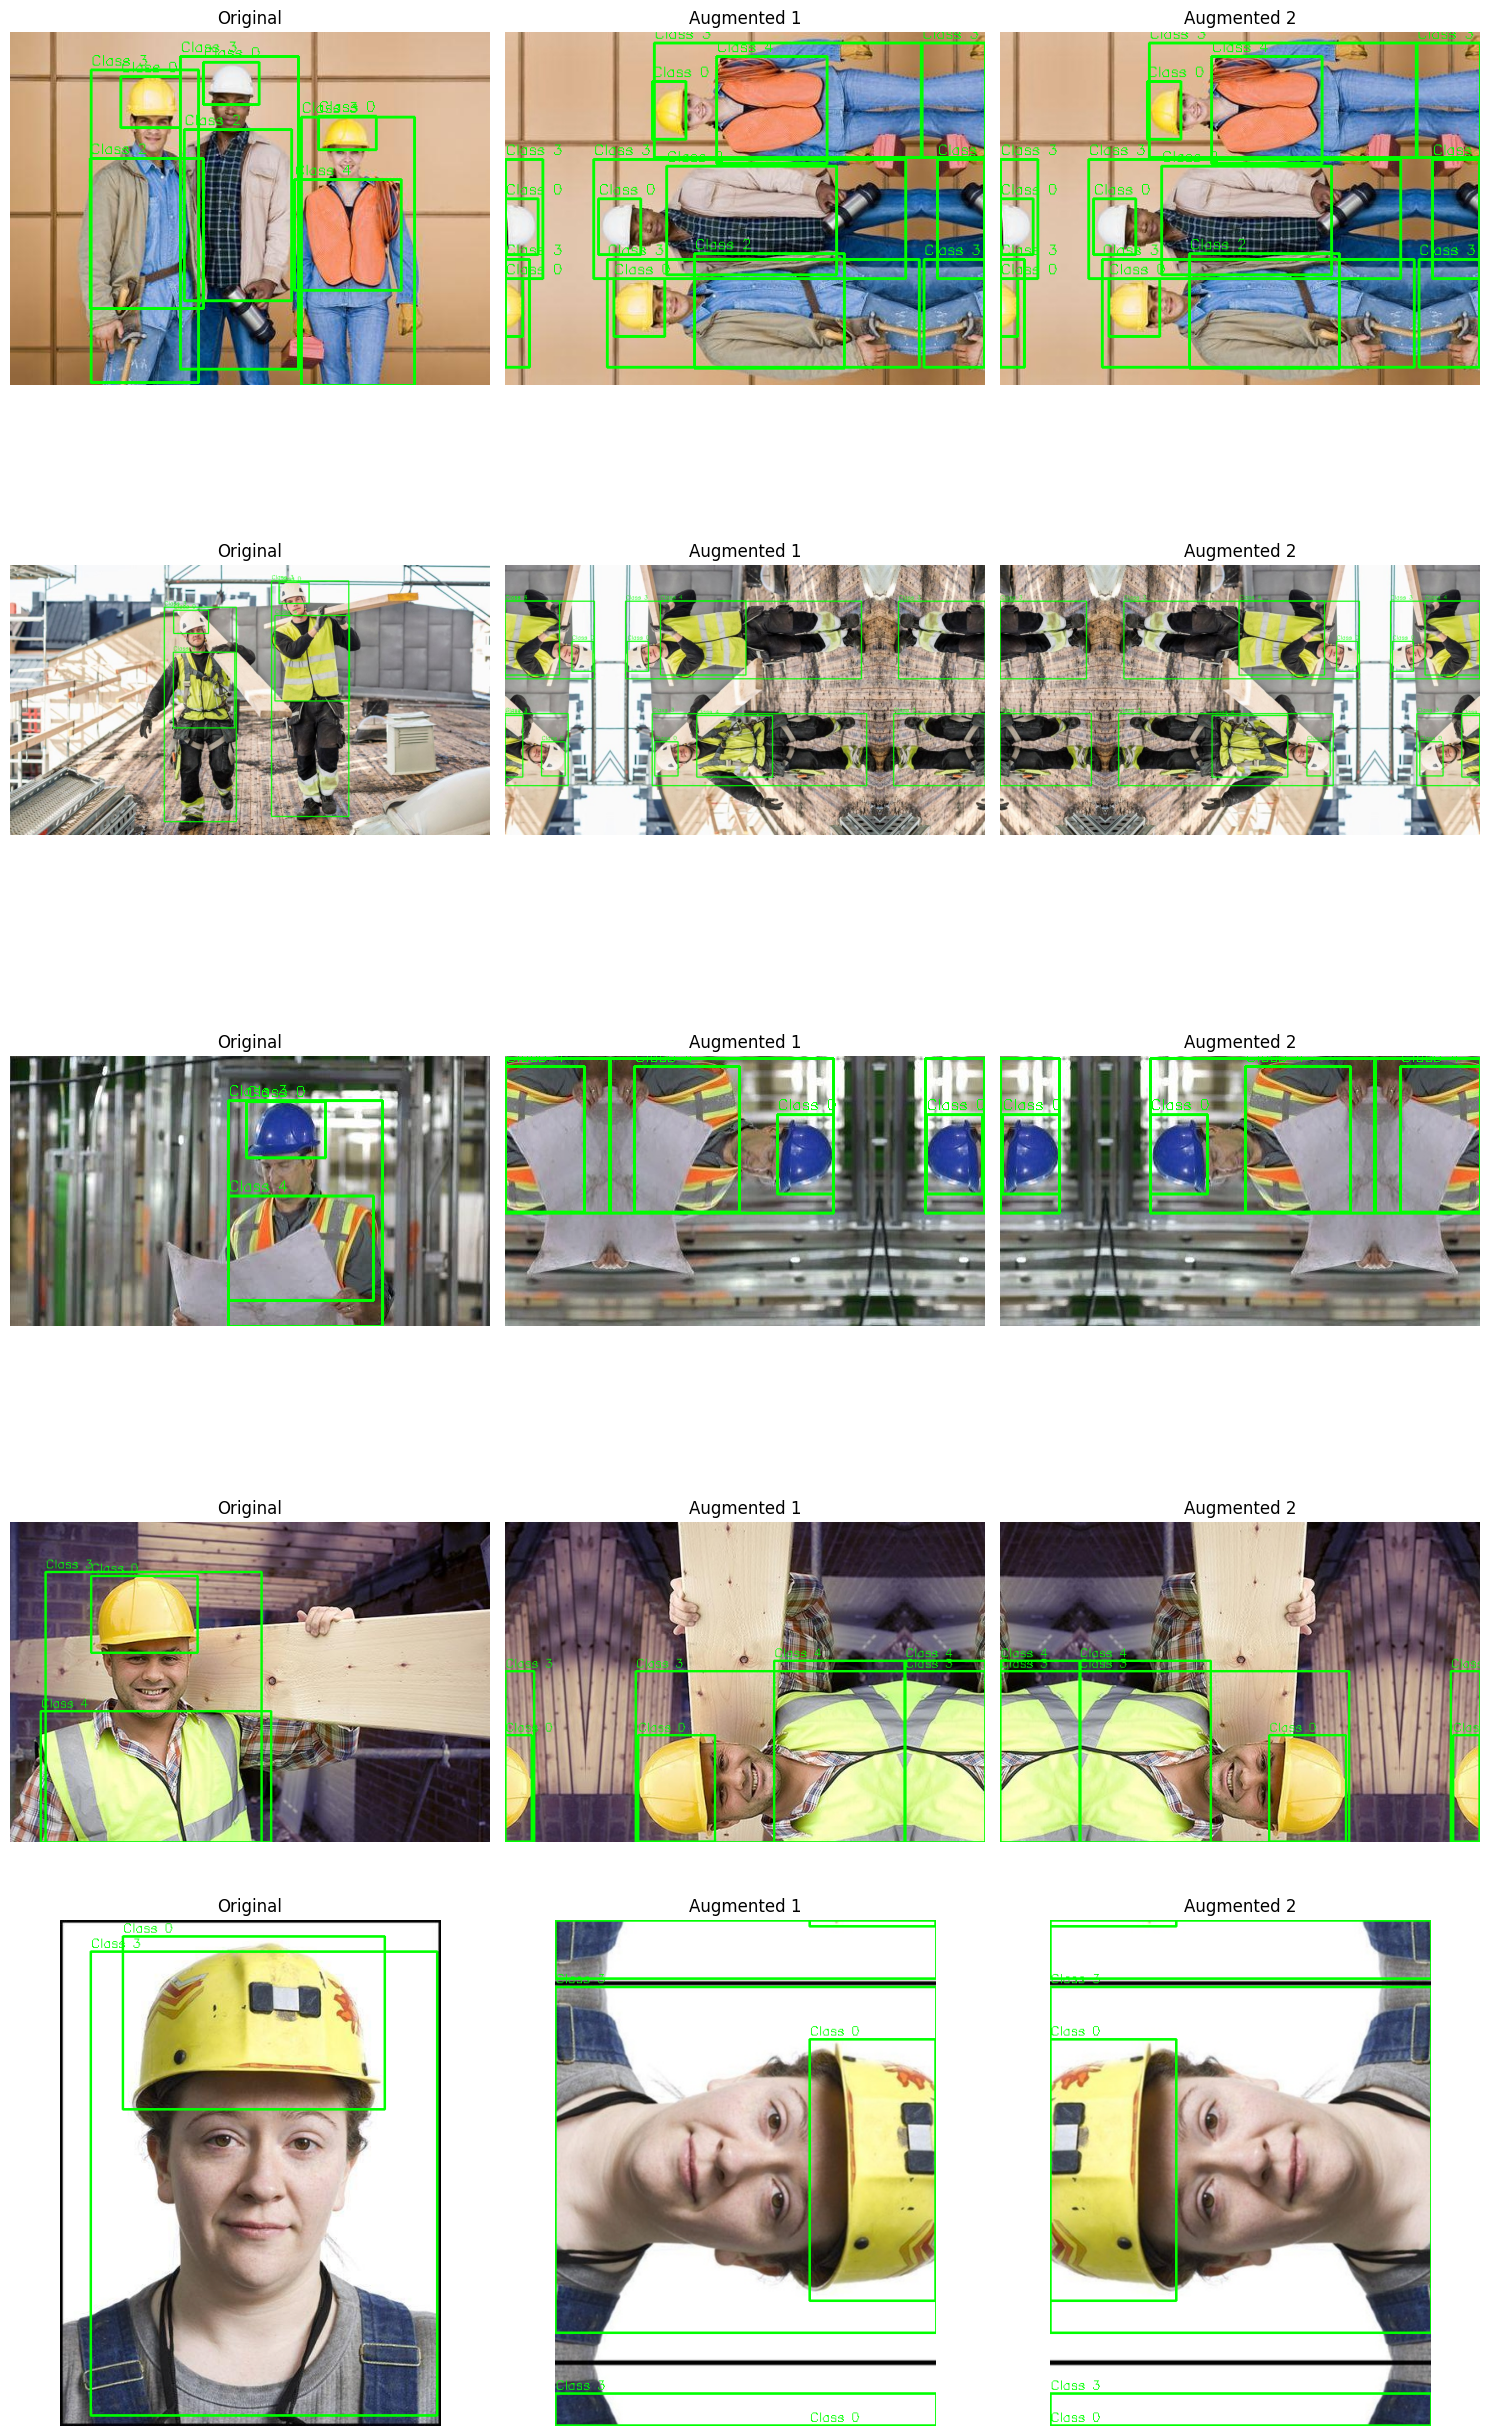

In [ ]:
display_original_with_augmented_pairs(train_images_dir, train_labels_dir, aug_images_dir, aug_labels_dir, num_examples=5)

## Generate YAML configuration file

In [ ]:
CLASS_NAMES = ['helmet', 'no-helmet', 'no-vest', 'person', 'vest']

In [ ]:
import yaml
from pathlib import Path

def create_yaml_file(dataset_path, train_images, val_images, test_images=None, class_names=CLASS_NAMES):
    data = {
        'path': str(dataset_path),
        'train': str(Path(train_images).relative_to(dataset_path)),
        'val': str(Path(val_images).relative_to(dataset_path)),
    }

    if test_images:
        data['test'] = str(Path(test_images).relative_to(dataset_path))

    data['nc'] = len(class_names)
    data['names'] = class_names

    yaml_path = Path(dataset_path) / 'dataset.yaml'
    with open(yaml_path, 'w') as file:
        yaml.dump(data, file, default_flow_style=False)

    print(f"YAML file created at {yaml_path}")

In [ ]:
dataset_root = Path("/content/drive/MyDrive/AThanh/dataset")
train_images_dir = dataset_root / "train/images"
val_images_dir = dataset_root / "valid/images"
test_images_dir = dataset_root / "test/images"

In [ ]:
create_yaml_file(dataset_root, train_images_dir, val_images_dir, test_images_dir, class_names=CLASS_NAMES)

YAML file created at /content/drive/MyDrive/AThanh/dataset/dataset.yaml


# Train YOLOv11 model

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
model = YOLO("yolo11n.pt")

results = model.train(
    data="/content/drive/MyDrive/AThanh/dataset/dataset.yaml",
    epochs=50,
    batch=16,
    lr0=1e-4,
    imgsz=640,
)

metrics = model.val()

print(metrics)

100%|██████████| 5.35M/5.35M [00:00<00:00, 139MB/s]


Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/AThanh/dataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

100%|██████████| 755k/755k [00:00<00:00, 43.8MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/AThanh/dataset/train/labels... 997 images, 0 backgrounds, 0 corrupt: 100%|██████████| 997/997 [00:15<00:00, 62.40it/s]


train: New cache created: /content/drive/MyDrive/AThanh/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/AThanh/dataset/valid/labels... 119 images, 0 backgrounds, 0 corrupt: 100%|██████████| 119/119 [01:00<00:00,  1.98it/s]

val: New cache created: /content/drive/MyDrive/AThanh/dataset/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.78G      1.405      2.726      1.409         94        640: 100%|██████████| 63/63 [00:38<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        119        715      0.981      0.126      0.388      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.71G      1.416      1.409      1.406         61        640: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        119        715      0.671      0.484      0.551      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.92G      1.403      1.285      1.379         59        640: 100%|██████████| 63/63 [00:35<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        119        715      0.696        0.5      0.563      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.73G      1.392      1.213      1.367         60        640: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all        119        715      0.713      0.537      0.591      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.63G      1.367      1.171       1.35         40        640: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        119        715      0.842      0.559      0.649      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.71G      1.381      1.146      1.352         74        640: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        119        715       0.69      0.681      0.726      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.7G       1.35      1.108       1.34         75        640: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        119        715      0.667       0.65      0.747      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.77G      1.341      1.069      1.323         68        640: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        119        715      0.775      0.642      0.739      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.56G      1.314      1.033      1.307         45        640: 100%|██████████| 63/63 [00:36<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        119        715      0.754      0.725      0.791      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.59G      1.315      1.007      1.318         35        640: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        119        715      0.683      0.765      0.763      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.7G      1.314     0.9904      1.293         82        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        119        715      0.803      0.731      0.809      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.73G       1.31     0.9688      1.298         44        640: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        119        715      0.778      0.744       0.79      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.79G      1.289     0.9491      1.292         52        640: 100%|██████████| 63/63 [00:34<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        119        715      0.804      0.769      0.826      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.66G      1.284     0.9232      1.278         54        640: 100%|██████████| 63/63 [00:33<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        119        715      0.776      0.742      0.792      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.86G      1.266     0.9039      1.277         98        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        119        715       0.84       0.73       0.81      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.88G      1.276      0.894      1.265        103        640: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        119        715      0.753      0.748      0.789      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.74G      1.262     0.8818      1.269         66        640: 100%|██████████| 63/63 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        119        715      0.775      0.781      0.819      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.99G       1.26     0.8613      1.266         39        640: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        119        715      0.734      0.797      0.828      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.56G      1.261     0.8628      1.267         49        640: 100%|██████████| 63/63 [00:32<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all        119        715      0.802      0.777      0.805      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.83G      1.233     0.8297      1.251         42        640: 100%|██████████| 63/63 [00:32<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        119        715      0.809      0.799      0.834       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.88G      1.234     0.8254      1.244         64        640: 100%|██████████| 63/63 [00:32<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        119        715      0.827      0.749      0.844      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.64G      1.236     0.8192      1.254         58        640: 100%|██████████| 63/63 [00:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        119        715      0.824      0.741      0.839      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.93G      1.218     0.8172      1.233         28        640: 100%|██████████| 63/63 [00:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        119        715      0.784      0.848      0.858       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.71G      1.211     0.7966      1.234        105        640: 100%|██████████| 63/63 [00:31<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        119        715      0.778      0.785      0.839      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.88G      1.226      0.802      1.235         57        640: 100%|██████████| 63/63 [00:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        119        715      0.871      0.767      0.863      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.93G      1.191     0.7725      1.222         36        640: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        119        715      0.845      0.772      0.866      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.75G      1.195     0.7723      1.224         89        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

                   all        119        715      0.793      0.783      0.843      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.73G      1.182     0.7734      1.221         50        640: 100%|██████████| 63/63 [00:36<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        119        715      0.837      0.787      0.841      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.69G      1.171     0.7427      1.214         73        640: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        119        715      0.808      0.852      0.877      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.68G      1.176     0.7476      1.207         64        640: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        119        715      0.847      0.828       0.87      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.69G      1.179     0.7356      1.213         62        640: 100%|██████████| 63/63 [00:34<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        119        715      0.791      0.831      0.857      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.67G      1.167     0.7346      1.208         29        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        119        715      0.809      0.811      0.864      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.76G      1.145     0.7173      1.196         63        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        119        715      0.892      0.765      0.867      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.66G      1.148     0.7082      1.204         52        640: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        119        715      0.876      0.801      0.872      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.84G      1.132     0.7077      1.195         67        640: 100%|██████████| 63/63 [00:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        119        715      0.864      0.795      0.871      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.79G      1.129     0.6988      1.184         69        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        119        715      0.829      0.783       0.85      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.73G      1.116     0.6825      1.184         78        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        119        715       0.85        0.8      0.864      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.85G      1.113     0.6802      1.171         70        640: 100%|██████████| 63/63 [00:33<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        119        715      0.904      0.804      0.878      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.72G      1.115     0.6784       1.17         61        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        119        715      0.874      0.812      0.887      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.68G      1.102     0.6635      1.175         51        640: 100%|██████████| 63/63 [00:36<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        119        715      0.883       0.82      0.891      0.498


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.58G      1.083     0.6283      1.168         40        640: 100%|██████████| 63/63 [00:37<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        119        715      0.865      0.834      0.884      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.46G      1.053     0.5943      1.156         24        640: 100%|██████████| 63/63 [00:34<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        119        715      0.817      0.819      0.867      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.47G      1.037     0.5819      1.137         31        640: 100%|██████████| 63/63 [00:35<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        119        715      0.834      0.853      0.889      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.46G      1.038     0.5831      1.141         32        640: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        119        715       0.87      0.831      0.874      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.54G      1.024      0.564       1.13         24        640: 100%|██████████| 63/63 [00:32<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        119        715       0.78      0.849       0.89      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.61G      1.007     0.5536      1.119         19        640: 100%|██████████| 63/63 [00:29<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        119        715      0.888      0.843      0.916      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.5G     0.9972     0.5421      1.118         34        640: 100%|██████████| 63/63 [00:30<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        119        715      0.884      0.859      0.909      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.53G     0.9948      0.547      1.119         61        640: 100%|██████████| 63/63 [00:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        119        715      0.844      0.856      0.902      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.49G     0.9858     0.5409      1.111         26        640: 100%|██████████| 63/63 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all        119        715       0.88       0.84        0.9      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       2.5G     0.9713     0.5288      1.109         27        640: 100%|██████████| 63/63 [00:35<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        119        715      0.891      0.836      0.906      0.505



50 epochs completed in 0.538 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


                   all        119        715      0.888      0.859      0.909      0.508
                helmet        117        232        0.9       0.94      0.949      0.561
             no-helmet          6         11      0.927      0.727      0.854      0.342
               no-vest         52         90      0.791      0.822      0.846      0.438
                person        115        241       0.91      0.954       0.96      0.661
                  vest         74        141      0.909      0.851      0.938      0.539
Speed: 0.4ms preprocess, 5.2ms inference, 0.0ms loss, 8.4ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/drive/MyDrive/AThanh/dataset/valid/labels.cache... 119 images, 0 backgrounds, 0 corrupt: 100%|██████████| 119/119 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


                   all        119        715      0.894      0.852      0.903       0.51
                helmet        117        232      0.897      0.931      0.943      0.562
             no-helmet          6         11      0.959      0.727      0.832       0.35
               no-vest         52         90      0.794        0.8      0.839      0.433
                person        115        241      0.909      0.955      0.959      0.664
                  vest         74        141       0.91      0.844       0.94       0.54
Speed: 0.4ms preprocess, 11.1ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d820d3cc6d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_resu

                             Metric     Value
0  Mean Average Precision (mAP@0.5)  0.902571
1                         Precision  0.893566
2                            Recall  0.851530


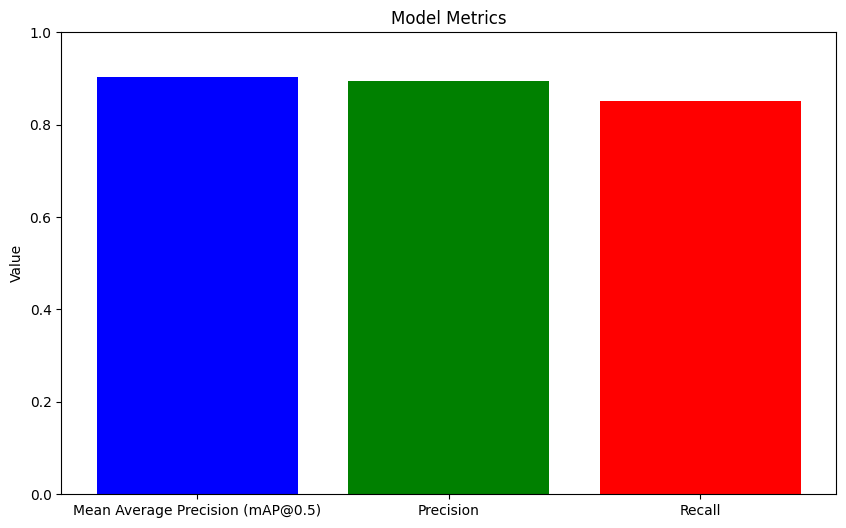

In [ ]:
mAP50 = metrics.results_dict.get('metrics/mAP50(B)', 0)
precision = metrics.results_dict.get('metrics/precision(B)', 0)
recall = metrics.results_dict.get('metrics/recall(B)', 0)

metrics_df = pd.DataFrame({
    "Metric": ["Mean Average Precision (mAP@0.5)",
               "Precision", "Recall"],
    "Value": [mAP50, precision, recall]
})

print(metrics_df)

plt.figure(figsize=(10, 6))
plt.bar(metrics_df["Metric"], metrics_df["Value"], color=['blue', 'green', 'red'])
plt.title("Model Metrics")
plt.ylabel("Value")
plt.ylim(0, 1)
plt.show()

# Exporting model to Hugging Face

In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")

model.export(format="onnx")

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 164.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 201.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 230.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 133.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 280.1 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 23.8s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for upd

'runs/detect/train/weights/best.onnx'

## Deploy model on Hugging Face

In [ ]:
from huggingface_hub import HfApi, HfFolder, Repository
import locale

In [ ]:
# Define a function to override the default locale setting with UTF-8. This comes from search result [2]
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

In [ ]:
# Override locale settings
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The token `luanle13` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate

In [ ]:
from huggingface_hub import create_repo, upload_file

repo_id = "ltl1313ltl/construction-safety"

upload_file(
    path_or_fileobj="runs/detect/train/weights/best.pt",
    path_in_repo="model.pt",
    repo_id=repo_id,
    repo_type="model"
)

print(f"Model uploaded!")

best.pt:   0%|          | 0.00/5.47M [00:00<?, ?B/s]

Model uploaded!



image 1/1 /content/pic3.png: 384x640 3 helmets, 3 no-vests, 3 persons, 77.7ms
Speed: 2.1ms preprocess, 77.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


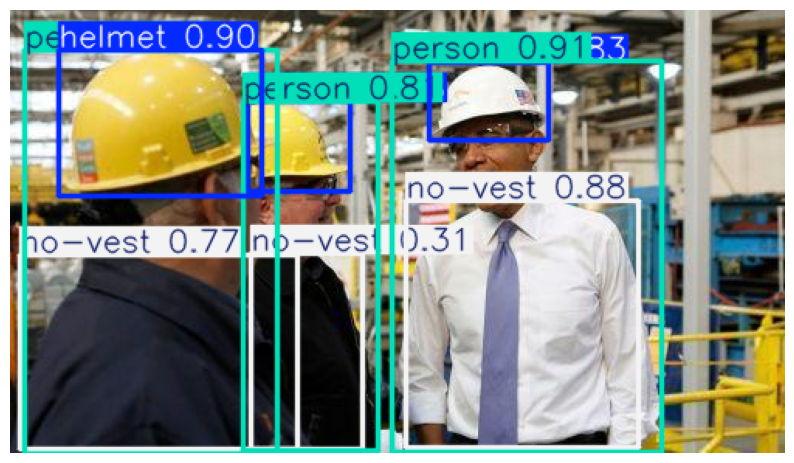

In [ ]:
trained_model = YOLO('/content/runs/detect/train/weights/best.pt')

test_image_path = '/content/pic3.png'

results = trained_model.predict(test_image_path, save=True, save_txt=True)

for result in results:
    img = result.plot()
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()